# Segmentation

In this homework you are going to implement and train a UNet model for image segmentation

In [ ]:
import os
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as pth_transforms
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from PIL import Image
from tqdm.auto import tqdm

## Data

We are going to use camvid dataset for image segmentation

In [ ]:
!wget --quiet --show-progress https://www.dropbox.com/s/5pylcjrrrtybbmo/camvid.tar?dl=0 -O camvid.tar
!tar -xf camvid.tar

camvid.tar          100%[===================>] 179.24M   118MB/s    in 1.5s    


In [ ]:
def get_files(folder, name_filter=None, extension_filter=None):
    if not os.path.isdir(folder):
        raise RuntimeError("\"{0}\" is not a folder.".format(folder))

    if name_filter is None:
        name_cond = lambda filename: True
    else:
        name_cond = lambda filename: name_filter in filename

    if extension_filter is None:
        ext_cond = lambda filename: True
    else:
        ext_cond = lambda filename: filename.endswith(extension_filter)

    filtered_files = []

    for path, _, files in os.walk(folder):
        files.sort()
        for file in files:
            if name_cond(file) and ext_cond(file):
                full_path = os.path.join(path, file)
                filtered_files.append(full_path)

    return filtered_files


def pil_loader(data_path, label_path):
    data = Image.open(data_path)
    label = Image.open(label_path)
    return data, label


class CamVid(torch.utils.data.Dataset):
    train_folder = 'train'
    train_lbl_folder = 'trainannot'

    val_folder = 'val'
    val_lbl_folder = 'valannot'

    test_folder = 'test'
    test_lbl_folder = 'testannot'

    img_extension = '.png'

    color_encoding = OrderedDict([
        ('sky', (128, 128, 128)),
        ('building', (128, 0, 0)),
        ('pole', (192, 192, 128)),
        ('road_marking', (255, 69, 0)),
        ('road', (128, 64, 128)),
        ('pavement', (60, 40, 222)),
        ('tree', (128, 128, 0)),
        ('sign_symbol', (192, 128, 128)),
        ('fence', (64, 64, 128)),
        ('car', (64, 0, 128)),
        ('pedestrian', (64, 64, 0)),
        ('bicyclist', (0, 128, 192)),
        ('unlabeled', (0, 0, 0))
    ])

    def __init__(self,
                 root_dir,
                 mode='train',
                 transform=None,
                 label_transform=None,
                 loader=pil_loader):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.label_transform = label_transform
        self.loader = loader

        if self.mode.lower() == 'train':
            # Get the training data and labels filepaths
            self.train_data = get_files(
                os.path.join(root_dir, self.train_folder),
                extension_filter=self.img_extension)

            self.train_labels = get_files(
                os.path.join(root_dir, self.train_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'val':
            # Get the validation data and labels filepaths
            self.val_data = get_files(
                os.path.join(root_dir, self.val_folder),
                extension_filter=self.img_extension)

            self.val_labels = get_files(
                os.path.join(root_dir, self.val_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'test':
            # Get the test data and labels filepaths
            self.test_data = get_files(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.img_extension)

            self.test_labels = get_files(
                os.path.join(root_dir, self.test_lbl_folder),
                extension_filter=self.img_extension)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

    def __getitem__(self, index):
        """
        Args:
        - index (``int``): index of the item in the dataset
        Returns:
        A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
        of the image.
        """
        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[
                index]
        elif self.mode.lower() == 'val':
            data_path, label_path = self.val_data[index], self.val_labels[
                index]
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[
                index]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

        img, label = self.loader(data_path, label_path)

        if self.transform is not None:
            img = self.transform(img)

        if self.label_transform is not None:
            label = self.label_transform(label)

        return img, label

    def __len__(self):
        """Returns the length of the dataset."""
        if self.mode.lower() == 'train':
            return len(self.train_data)
        elif self.mode.lower() == 'val':
            return len(self.val_data)
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

In [ ]:
train_ds = CamVid("CamVid")
valid_ds = CamVid("CamVid", mode="val")

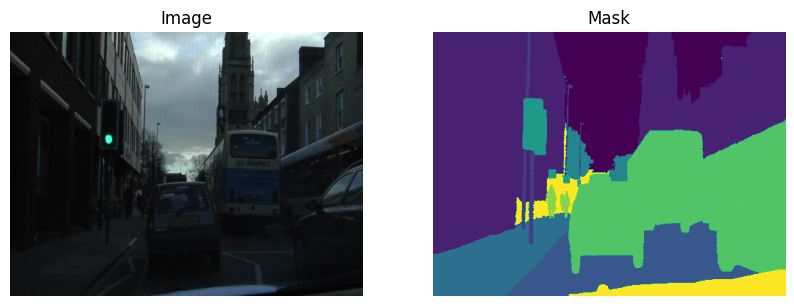

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,7), dpi=100)

ax1.imshow(train_ds[0][0])
ax1.set_title("Image")
ax1.axis(False)

ax2.imshow(train_ds[0][1])
ax2.set_title("Mask")
ax2.axis(False)

fig.show()

## Training

We advice you to use some resnet (18/50/101 -- doesn't matter) as a backbone and add upsample and decode layers on top of it. This way you could use the pretrained weights and get better segmentation with transfer learning

In this task you should:

* Add a decoder to the UNet model. The decoder should have $5$ blocks ($4$ for each res block in resnet and $1$ final block.
* Write a forward mehtod which applies resnet encoder block by block (while saving intermideate features for skip connections), and then the decoder
* Use cross entropy loss on the output of the network to train it.
* Visualize predictions on the validation set

In [ ]:
def upblock(in_ch, out_ch):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_ch),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torchvision.models.resnet50(pretrained=True)
        for p in self.encoder.parameters():
            p.requieres_grad = False

        sizes = [getattr(self.encoder, f'layer{i}')[2].conv3.weight.size(0) for i in range(1, 5)]

        self.up1 = upblock(sizes[3], sizes[3]//2)
        self.up2 = upblock(sizes[3], sizes[2]//2)
        self.up3 = upblock(sizes[2], sizes[1]//2)
        self.up4 = upblock(sizes[1], sizes[0]//2)
        self.last_conv = nn.Conv2d(sizes[0]//2, 13, 3, padding=1)


    def forward(self, img):
        x = self.encoder.conv1(img)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)

        # Resnet backbone
        x0 = self.encoder.maxpool(x)
        x1 = self.encoder.layer1(x0)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)

        # Upsampling with skip connections
        x = torch.cat([x3, self.up1(x)], dim=1)
        x = torch.cat([x2, self.up2(x)], dim=1)
        x = torch.cat([x1, self.up3(x)], dim=1)
        x = self.up4(x)
        x = self.last_conv(x)

        return x

In [ ]:
transform = pth_transforms.Compose([
    pth_transforms.Resize((256,256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

label_transform = pth_transforms.Compose([
    pth_transforms.Resize((128,128), pth_transforms.InterpolationMode.NEAREST),
    pth_transforms.Lambda(lambda x: torch.tensor(np.array(x)))
])


train_ds = CamVid("CamVid", transform=transform, label_transform=label_transform)
valid_ds = CamVid("CamVid", mode="val", transform=transform, label_transform=label_transform)

train_loader = torch.utils.data.DataLoader(train_ds, 32, shuffle=True, pin_memory=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_ds, 32, shuffle=False, drop_last=False, pin_memory=True, num_workers=2)

Basic training loop:

In [ ]:
torch.manual_seed(10)

model = UNet().cuda()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(10)):
    pbar = tqdm(train_loader, desc=f"Train epoch {e}", leave=False)
    train_losses = []

    for batch in pbar:
        img, ann = batch
        img = img.cuda()
        ann = ann.long().cuda()

        out = model(img)
        loss = F.cross_entropy(out, ann.long())
        loss.backward()
        opt.step()
        opt.zero_grad()

        pbar.set_postfix(loss=loss.item())
        train_losses.append(loss.item())

    pbar = tqdm(train_loader, desc=f"Val epoch {e}", leave=False)
    val_losses = []

    for batch in pbar:
        with torch.no_grad():
            img, ann = batch
            img = img.cuda()
            ann = ann.long().cuda()

            out = model(img)
            loss = F.cross_entropy(out, ann.long())
            val_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(train_losses):.3f}; Val loss {np.mean(val_losses):.3f};")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 done; Train loss 1.289; Val loss 0.738;


Epoch 1 done; Train loss 0.645; Val loss 0.563;


Epoch 2 done; Train loss 0.520; Val loss 0.478;


Epoch 3 done; Train loss 0.465; Val loss 0.427;


Epoch 4 done; Train loss 0.410; Val loss 0.391;


Epoch 5 done; Train loss 0.377; Val loss 0.368;


Epoch 6 done; Train loss 0.363; Val loss 0.335;


Epoch 7 done; Train loss 0.326; Val loss 0.318;


Epoch 8 done; Train loss 0.309; Val loss 0.298;


Epoch 9 done; Train loss 0.316; Val loss 0.300;



Lets make sure that model predicts correct masks:

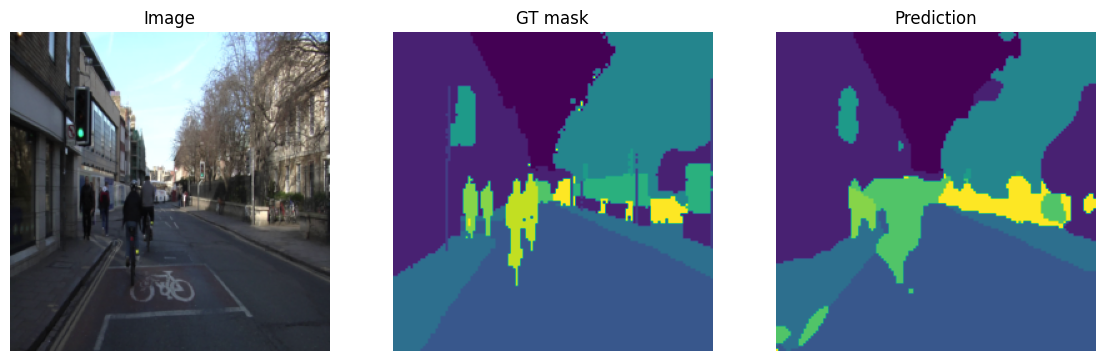

In [ ]:
img, ann = valid_ds[60]

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,7), dpi=100)

ax1.imshow(img.permute(1,2,0) * torch.tensor([0.229, 0.224, 0.225])[None,None,:] + torch.tensor([0.485, 0.456, 0.406])[None,None,:])
ax1.set_title("Image")
ax1.axis(False)

ax2.imshow(ann)
ax2.set_title("GT mask")
ax2.axis(False)

pred = model(img[None].cuda())
ax3.imshow(pred.squeeze().argmax(dim=0).cpu())
ax3.set_title("Prediction")
ax3.axis(False)
fig.show()